In [4]:
import IPython
IPython.Application.instance().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [5]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2025-09-25 04:58:34--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 52.84.20.105, 52.84.20.7, 52.84.20.100, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|52.84.20.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz.2’

v1.0-mini.tgz.2     100%[===================>]   3.88G   251MB/s    in 24s     

2025-09-25 04:58:58 (167 MB/s) - ‘v1.0-mini.tgz.2’ saved [4167696325/4167696325]



In [4]:
!ls /data/sets/nuscenes

maps  samples  sweeps  v1.0-mini


In [3]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.591 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [43]:
scene = nusc.scene[0]
scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [24]:
import os, datetime, gc, math
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import imageio.v3 as iio
import matplotlib.pyplot as plt

OUT_DIR = Path("/content/nusc_frames")
VIDEO_PATH = "/content/MLP_data.mp4"
OUT_DIR.mkdir(parents=True, exist_ok=True)

channels = ['CAM_FRONT_LEFT','CAM_FRONT','CAM_FRONT_RIGHT','LIDAR_TOP']
fps = 4

In [25]:
def iteration_samples_in_scene(nusc, scene):
    token = scene['first_sample_token']
    while True:
        sample = nusc.get('sample', token)
        yield sample
        if sample['next'] == '':
            break
        token = sample['next']

In [39]:
def compose_frame(cam_left_path, cam_front_path, cam_right_path, lidar_path):
    # load images
    L = Image.open(cam_left_path).convert("RGB")
    C = Image.open(cam_front_path).convert("RGB")
    R = Image.open(cam_right_path).convert("RGB")
    Li = Image.open(lidar_path).convert("RGB")

    # normalize heights for the camera strip
    # adjustable
    target_h = 480
    def resize_h(img, h=target_h):
        w, h0 = img.size
        scale = h / h0
        return img.resize((int(w*scale), h), Image.BILINEAR)

    L, C, R = map(resize_h, [L, C, R])
    top_w = L.width + C.width + R.width
    top_strip = Image.new("RGB", (top_w, target_h), (255,255,255))
    x = 0
    for img in [L, C, R]:
        top_strip.paste(img, (x, 0))
        x += img.width

    # scale LiDAR to same width as the camera strip
    Li_scale = top_w / Li.width
    Li = Li.resize((top_w, int(Li.height * Li_scale)), Image.BILINEAR)

    # stack vertically with small padding
    pad = 8
    frame = Image.new("RGB", (top_w, top_strip.height + pad + Li.height), (255,255,255))
    frame.paste(top_strip, (0, 0))
    frame.paste(Li, (0, top_strip.height + pad))
    return frame

In [46]:
import imageio
import numpy as np

writer = imageio.get_writer(VIDEO_PATH, fps=fps, codec="libx264", quality=8)

for sample in iteration_samples_in_scene(nusc, scene):

    # render each view to temp files
    sd = sample['data']
    camL_path = OUT_DIR / f"{sample['token']}_CAML.png"
    camC_path = OUT_DIR / f"{sample['token']}_CAMC.png"
    camR_path = OUT_DIR / f"{sample['token']}_CAMR.png"
    lidar_path = OUT_DIR / f"{sample['token']}_LIDAR.png"

    # render and save images to disk
    nusc.render_sample_data(sd['CAM_FRONT_LEFT'], out_path=str(camL_path), with_anns=True)
    nusc.render_sample_data(sd['CAM_FRONT'],      out_path=str(camC_path), with_anns=True)
    nusc.render_sample_data(sd['CAM_FRONT_RIGHT'],out_path=str(camR_path), with_anns=True)
    nusc.render_sample_data(sd['LIDAR_TOP'],      out_path=str(lidar_path), with_anns=True)
    plt.close('all')


    # compose + timestamp
    frame = compose_frame(camL_path, camC_path, camR_path, lidar_path)

    # write video frame
    # convert PIL Image to numpy array
    writer.append_data(np.asarray(frame))

    # clean up
    frame.close(); gc.collect()

writer.close()

In [6]:
!ls /data/sets/nuscenes

maps  samples  sweeps  v1.0-mini


In [8]:
first_sample_token = my_scene['first_sample_token']
first_sample_token

'ca9a282c9e77460f8360f564131a8af5'

In [9]:
my_sample = nusc.get('sample', first_sample_token)

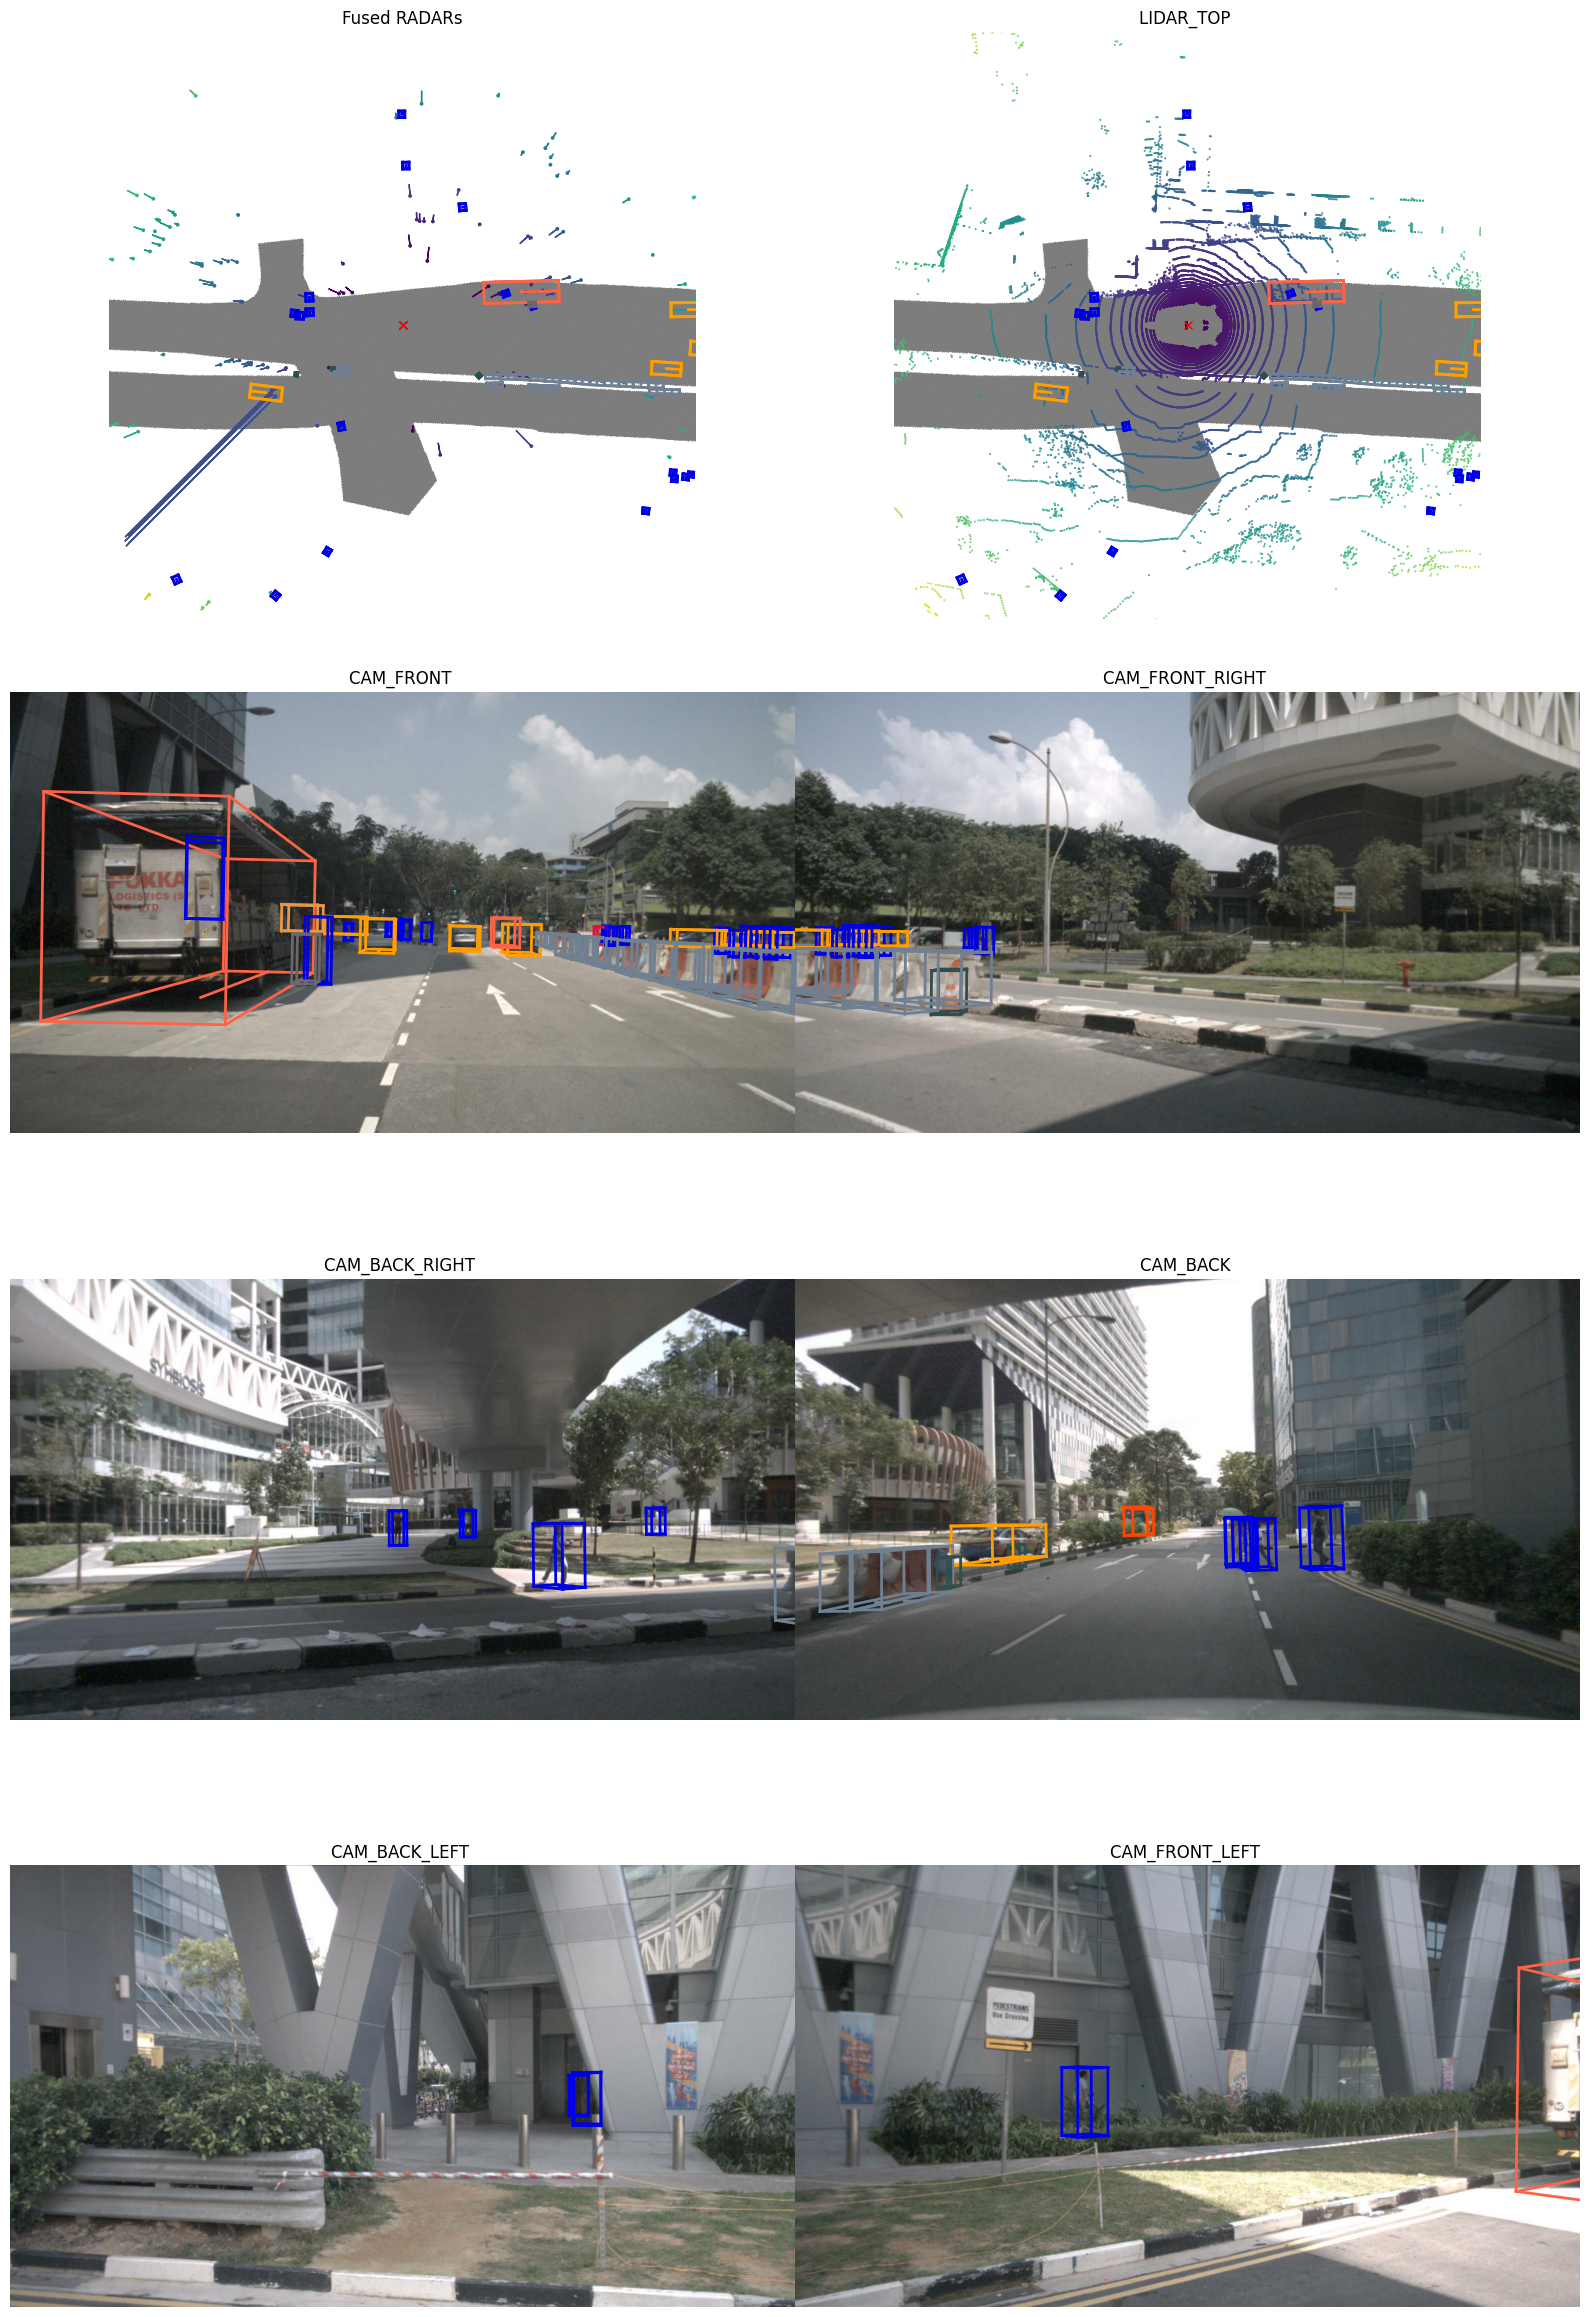

In [12]:
nusc.render_sample(first_sample_token)

In [13]:
# ID of one specific sample_annotation(one labeled object at one timestamp)
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
# fetching the reference ID
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']
visibility_token

'4'

Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}


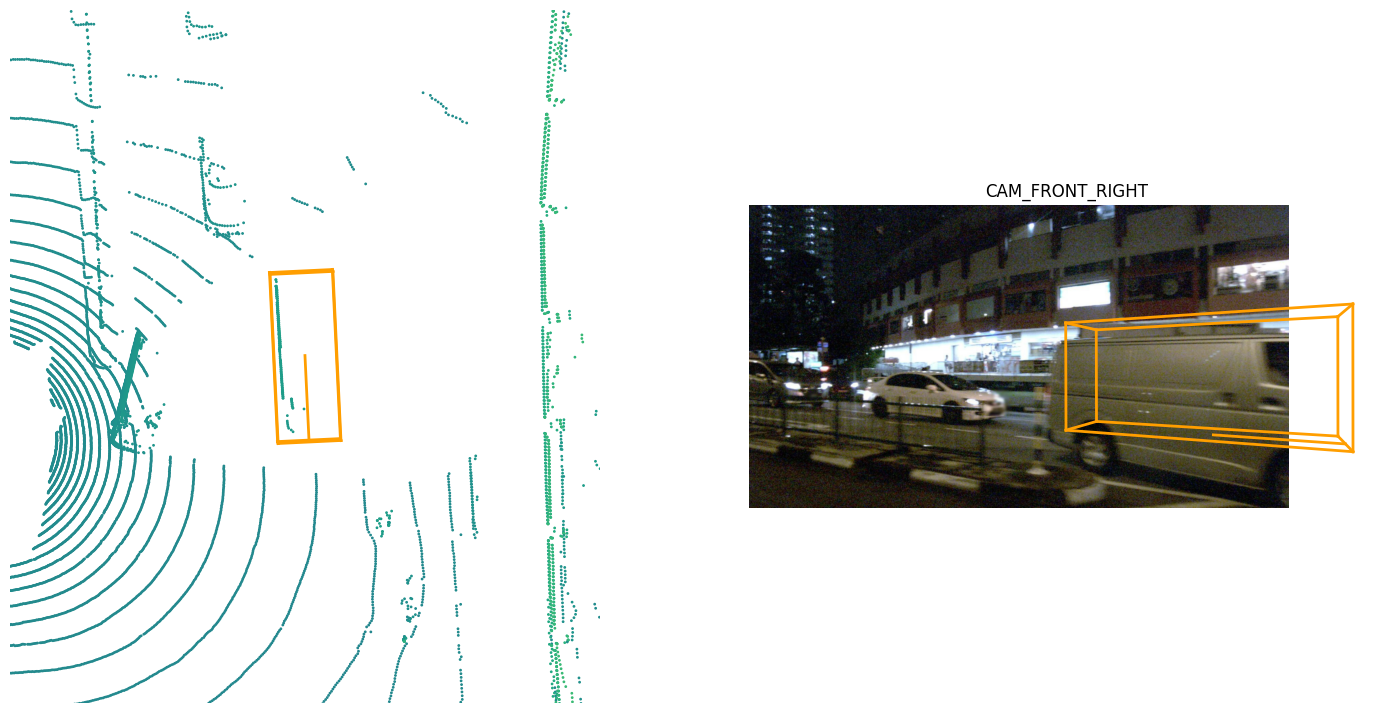

In [15]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

In [16]:
sample = nusc.get('sample_annotation', anntoken)

In [17]:
sample

{'token': '9f450bf6b7454551bbbc9a4c6e74ef2e',
 'sample_token': '3b594af1b130490989536590345c9dc9',
 'instance_token': 'a0328b62fcaa46a093c7de5ae9b53ecf',
 'visibility_token': '1',
 'attribute_tokens': ['c3246a1e22a14fcb878aa61e69ae3329'],
 'translation': [1494.609, 1208.402, 1.339],
 'size': [2.424, 6.524, 3.065],
 'rotation': [0.846007105692655, 0.0, 0.0, 0.533171620697817],
 'prev': '5404bbb690a14a7d99684988237fc9ef',
 'next': 'a991475c7d584659b43a5aa4934d53ca',
 'num_lidar_pts': 170,
 'num_radar_pts': 0,
 'category_name': 'vehicle.car'}

In [20]:
# first sample (a keyframe in the scene)
first_sample = nusc.get('sample', scene['first_sample_token'])

# get the annotations attached to this sample, a list of annotation tokens
anns = first_sample['anns']

Datetime: 2018-07-24 03:28:47.647951


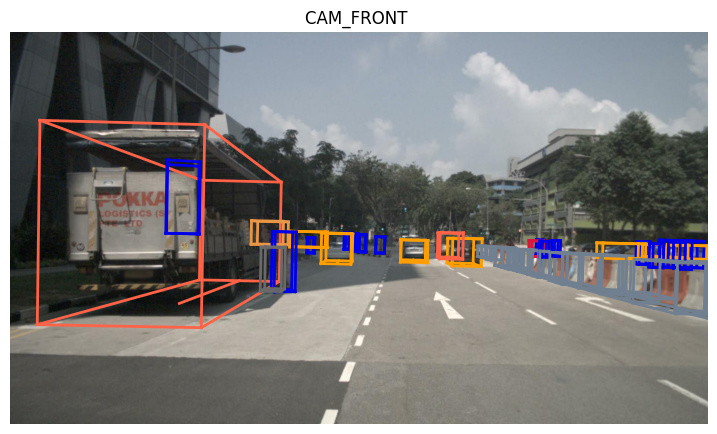

In [49]:
import datetime

token = scene['first_sample_token']
# channels = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'LIDAR_TOP']
channels = ['CAM_FRONT']
for i in range(1):
    sample = nusc.get('sample', token)

    # convert microseconds to seconds
    t = sample['timestamp']
    ts = t / 1e6
    dt = datetime.datetime.fromtimestamp(ts)
    print("Datetime:", dt)
    for ch in channels:
      # jump from sample to sample_data token
      sd_token = sample['data'][ch]
      nusc.render_sample_data(sd_token, with_anns=True)

    # last frame reached
    if sample['next'] == '':
        break
    token = sample['next']

